## Targeting Percentage of Market's Speed of Trading (Chapter 9.2)

This file implements the optimal excusion strategy when the agent targets a percentage of the speed at which the markt participants are trading. The theory is covered in Chapter 9.2 of

<em>Algorithmic and High-Frequency Trading </em>
<br>(c) Cartea, Jaimungal, & Penalva
<br>2015 Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

The agent's aims to minimize the performance criterion
$$
\mathbb{E}\left[X_{T}^{\nu}+Q_{T}^{\nu}\left(S_{T}^{\nu}-\alpha Q_{T}^{\nu}\right)-\varphi \int_{0}^{T}\left(\nu_{u}-\rho \mu_{u}\right)^{2} d u\right]
$$

Here $\rho$ is the target ratio of the market speed, $\mu_t$ is the market trading speed, $\nu_t$ is the traders' execution speed, $Q_t^\nu$ denotes the agent's inventory, $X_t^\nu$ is the cash process, and $S_t^\nu$ is the midprice; each is assumed to satisfy the SDEs:
$$
d Q_{t}^{\nu} =  \nu_{t} d t
$$
$$
d X_{t}^{\nu}=(S_{t}^{\nu}-k \,\nu_{t})\, \nu_{t} d t
$$
$$
d S_{t}^{\nu}=-b\,\nu_{t}\, dt+\sigma \,dW_{t}
$$
and $W_t$ is a Brownian motion.


In the double limit of first ensuring full liquidation, and then forcing the tracking penalty to infinity, Section 9.2.3 shows that the optimal strategy is given by
$$
\lim_{\varphi\to\infty}\lim_{\alpha\to\infty} \nu_t^*
= \rho\,\left[\mu_t-\tfrac{1}{T-t}\int_t^T \mathbb{E}\left[\mu_u|\mathcal F_t^\mu \right]\,du\right] + \frac{Q_t^{\nu^*}}{T-t}
$$

Furthermore, when the market's order-flow rate $\mu_t$ satisfies the SDE
$$
d\mu_t = -\kappa\,\mu_t\,dt+\eta_{1+N_{t^-}}\,dN_t
$$
where $N_t$ is a Poisson process with intensity $\lambda$ and $\eta_1,\eta_2,\dots$ are iid exponential random variables with mean $\eta$, then we may express the optimal trading rate as

$$
\nu_t^*=\rho\left[\mu_t - \left((\mu_t-\psi)\frac{1-e^{-\kappa(T-t)}}{\kappa} + \psi(T-t)\right) \right] + \frac{Q_t^{\nu^*}}{T-t}
$$

where $\psi=\frac{\lambda\,\eta}{\kappa}$

In [1]:
# Importing Packages/Setting Global Parameters
import time
import math
import numpy as np
import matplotlib.pyplot as plt
with __import__('importnb').Notebook(): 
    import TargetRate_MarketSpeed_Helper
from scipy import interpolate
np.random.seed(30)
np.seterr(divide='ignore', invalid='ignore')
font = {'family': 'serif',
        'style': 'italic',
        # 'color': 'darkred',
        'weight': 1,
        'size': 16,
        }

## Initialize parameters

In [2]:
# Time grid
T = 1  # Expiry
Ndt = 1000  # Number of time increments
dt = T/Ndt  # Time change increment
t = np.arange(0, T+0.000001, dt)  # Time increments vector 

# Market Impact and Aversionn Parameters
k = 0.1  # Temporary Market Impact
rho = 0.05  # Target fraction of market speed
b = 0.1  # Permanent Price Impact Factor

# Price Variables
S0 = 20  # Initial Midprice
sigma = 0.5  # Volatilty (recall this is an artihmetic model)

# Volume Rate
eta = 10  # Jump Size (Exponential Jump Size)
lam = 50  # Rate of Arrival of Jumps (Poisson Process)
kappa = 20  # Rate of Mean-Reversion

psi = eta*lam/kappa  #

Nsims = 10000  # Number of Simulations

idxfig = [0,1,2] # Index of path to be plotted

## Strategy Simulation
Next, we look at how the strategy performs along simulated paths. We focus on the double limiting case of first ensuring all inventory is liquidated, and that the agent wishes to trade very close to POV (percentage of volume).

The simulation proceeds by  using the following steps:
* Decide on liquidation speed based on current inventory, and recent order-flow 
* Update inventory and cash
* Update market midprice and other agent's trading speed

In [3]:
# Initializing variables for simulation base on computed strategy

mu = np.full([Nsims, Ndt+1], np.nan)  # Trade Speed Matrix for Maket
S = np.full([Nsims, Ndt + 1], np.nan)  # Midprice Matrix
Vwap = np.full([Nsims, Ndt + 1], np.nan)  # Volume Weighted Average Price Matrix
Y = np.full([Nsims, Ndt + 1], np.nan)  # Accumulated Transaction Matrix
V = np.full([Nsims, Ndt + 1], np.nan)  # Traded Volume Matrix
S_hat = np.full([Nsims, Ndt+1], np.nan)  # Execution Price Matrix
Q = np.full([Nsims, Ndt + 1], np.nan)  # Inventory Matrix
X = np.full([Nsims, Ndt + 1], np.nan)  # Strategy Cost Matrix
nu = np.full([Nsims, Ndt + 1], np.nan)  # Optimal Liquidation Speed Matrix
corr_mat = np.full([Nsims, 1], np.nan)  # Market Trade Speed VS Liquidation Speed Correlation Matrix  

In [4]:
# Initial conditions
mu[:,0] = psi  # Setting Initial Market Trade Speed
S[:,0] = S0  # Setting Initial Midprice
Vwap[:,0] = S0  # Setting Initial Vwap
Y[:,0] = 0  # Setting Initial Accumulated Transactions
V[:,0] = 0  # Setting Initial Trade Volume
Q[:,0] = psi*rho*T  # Setting Initial Inventory
X[:,0] = 0  # Setting Initial Strategy Cost


In [5]:
for m in range(Ndt):

    # Time Remaining until Expiration
    tau = T-t[m]
        
    # Determine optimal liquidation speed
    A = (1-np.exp(-kappa*tau))/kappa
    B = (A*(mu[:,m]-psi) + tau*psi )/ (tau)
    
    nu[:,m] = rho*(mu[:,m] - B) + Q[:,m]/(tau)


    # determine execution Price
    S_hat[:,m] = S[:,m] - k * nu[:,m]*dt
      
    # Update Inventory and Cash Process
    X[:,m+1] = X[:,m] + np.multiply( S_hat[:,m], nu[:,m]*dt )
    Q[:,m+1] = Q[:,m] - nu[:,m]*dt

    
    # Update VWAP
    Y[:,m+1] = Y[:,m] + np.multiply(S[:,m], mu[:,m]) * dt
    V[:,m+1] = V[:,m] + mu[:,m] * dt
    Vwap[:,m+1] = np.divide(Y[:,m+1],V[:,m+1])
    
    # Update Midprice
    S[:,m+1] = S[:,m] + b*nu[:,m] * dt + (sigma*np.random.randn(Nsims,1)*(dt**0.5)).reshape(Nsims)
    
    # Update Other Agent's Trading Rates
    dN = [np.random.rand(Nsims,1) < (1-np.exp(-lam*dt))]
    etaSim = -eta*np.log(np.random.rand(Nsims,1))
    mu[:,m+1] = mu[:,m]*np.exp(-kappa*dt) + np.multiply(etaSim, dN).reshape(Nsims)
    
    

In [6]:
# Calculation the correlation between Market Trade Speed and Liquidation Speed
for i in range(Nsims):
    corr_mat[i] = np.corrcoef(nu[i,:-2], mu[i,:-2])[1,0]

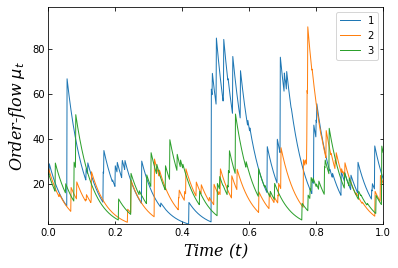

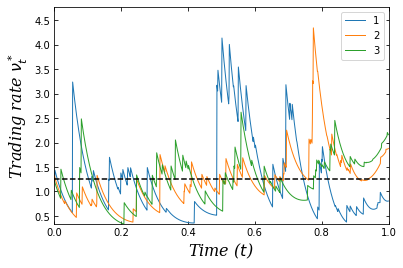

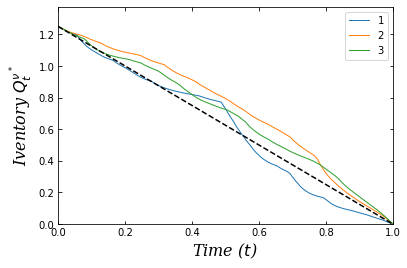

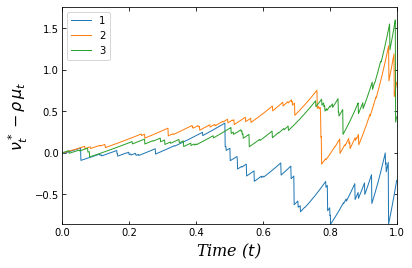

In [7]:
# Visualizing results 
TargetRate_MarketSpeed_Helper.PlotPath(t, T, mu, idxfig, "Order-flow $\mu_t$", lw=1)
TargetRate_MarketSpeed_Helper.PlotPath(t, T, nu, idxfig, "Trading rate " + r"$\nu^*_t$", lw=1, midline=[0, np.full(t.shape, Q[0,0]/T)])
TargetRate_MarketSpeed_Helper.PlotPath(t, T, Q, idxfig, r"Iventory " + r"$Q^{\nu^*}_t$", lw=1, midline=[0,Q[0,0]*(1-t/T)])
TargetRate_MarketSpeed_Helper.PlotPath(t, T, nu - rho*mu, idxfig, r"$\nu^*_t-\rho\,\mu_t$", lw=1)


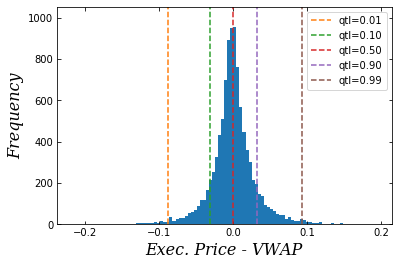

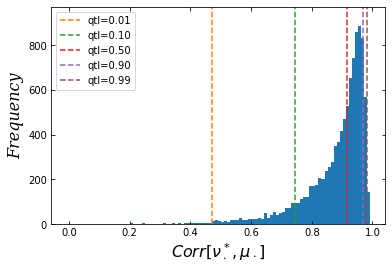

In [8]:
# Visualizing difference between cost per share and VWAP
TargetRate_MarketSpeed_Helper.PlotHist(X[:,-1]/Q[0,0] - Vwap[:,-1], 'Exec. Price - VWAP', bins=100)
# Visualizing the correlation matrix
TargetRate_MarketSpeed_Helper.PlotHist(corr_mat, r'$Corr[\nu^*_\cdot,\mu_\cdot]$', bins=100)


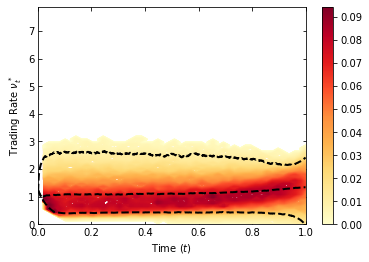

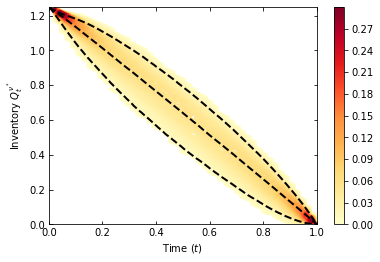

In [10]:
# Visualizing density plot of simulations
TargetRate_MarketSpeed_Helper.MakeHeatMap(t, nu, r'Time ($t$)', r'Trading Rate $\nu_t^*$', 11, 100, 100, 50, 0.01,0.2)
TargetRate_MarketSpeed_Helper.MakeHeatMap(t, Q, r'Time ($t$)', r'Inventory $Q_t^{\nu^*}$', 10, 100, 100, 50, 0.01,0.3)
